# Diamond sensor data collection and analysis

xchong@lbl.gov, awojdyla@lbl.gov, May 2024

# Step 1: Move the m101 pitch slightly and see what happens

In [1]:
import epics
import bluesky
import numpy as np

In [2]:
from ophyd import EpicsMotor
import ophyd
import ophyd_basler
from ophyd_basler.basler_camera import BaslerCamera

In [3]:
from blop.utils import prepare_re_env
%run -i $prepare_re_env.__file__ --db-type=temp

In [4]:
ophyd_basler.available_devices()
basler_camera= BaslerCamera(cam_num=2, verbose=True, name= "basler_cam",pixel_format="Mono12")

User-defined camera name    : ALS531-241-BW
Camera model                : a2A2448-23gcPRO
Camera serial number        : 40494690
Image shape (height, width) : (2048, 2448) pixels
Pixel format                : Mono12
Camera min. pixel level     : 0
Camera max. pixel level     : 4095
Grab timeout                : 5000 ms
Trigger mode                : Off
GigE transport payload size : 10,027,008 bytes


In [5]:
basler_camera.exposure_time
#basler_camera.exposure_time.put(100) #ms

ExposureTimeSignal(name='basler_cam_exposure_time', parent='basler_cam', value=1000.0, timestamp=1719619425.7674336)

In [58]:
energy = 9000
exposure_time=1

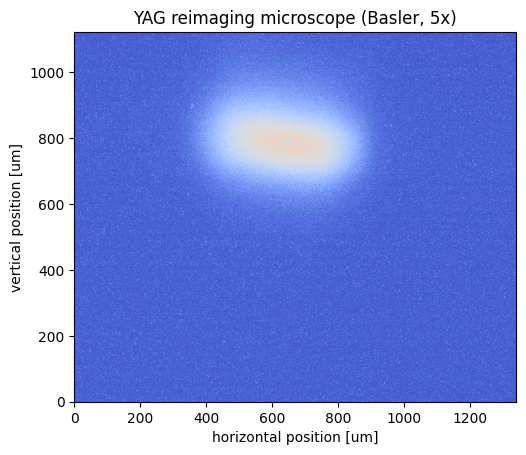

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

#pixel size for this model of the camera
px_m =2.74*1e-6
#effective pixel size
dx_m=px_m/5.0

y_m = np.arange(2048)*dx_m
x_m = np.arange(2448)*dx_m

res= basler_camera.grab_image()

plt.imshow(res,extent=[x_m[0]*1e6,x_m[-1]*1e6,y_m[0]*1e6,y_m[-1]*1e6])
plt.xlabel('horizontal position [um]')
plt.ylabel('vertical position [um]')
plt.title('YAG reimaging microscope (Basler, 5x)')
plt.show()

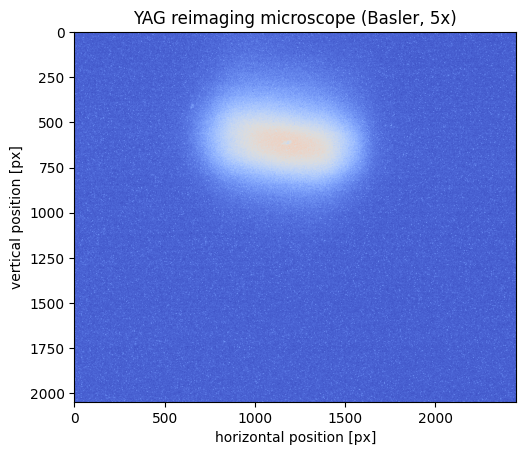

In [60]:
plt.imshow(res)
plt.xlabel('horizontal position [px]')
plt.ylabel('vertical position [px]')
plt.title('YAG reimaging microscope (Basler, 5x)')
plt.show()

In [61]:
def centroid1(x_px,I):
    xc_px = np.sum(I*x_px)/np.sum(I)
    return xc_px

def size_rms1(x_px,I):
    xc_px = centroid1(x_px,I)
    stdev = np.sqrt(np.sum(I*(x_px-xc_px)**2)/np.sum(I))
    return stdev

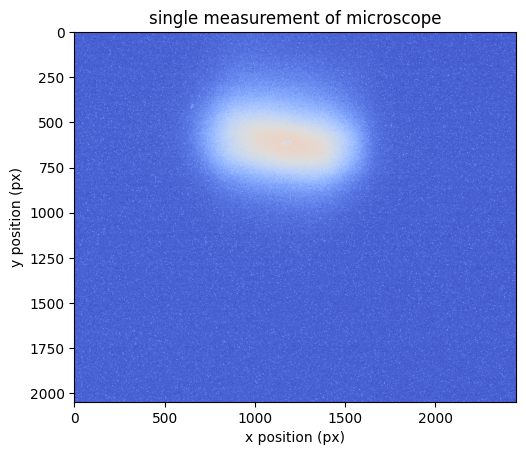

In [62]:
Nx = 2448
x_px = np.arange(Nx)
Ny = 2048
y_px = np.arange(Ny)


source_gaussian = res
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of microscope")
plt.imshow(source_gaussian)
plt.show()

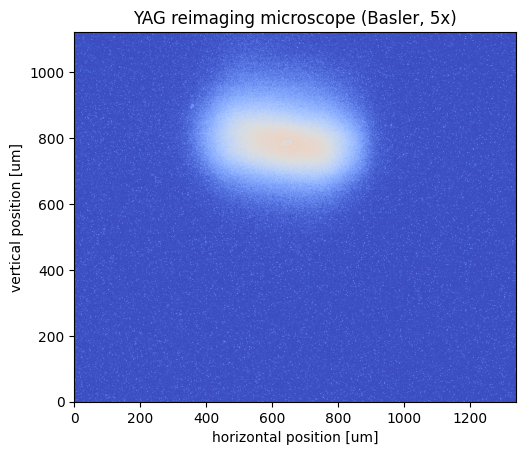

In [63]:
source_gaussian_masked = np.where(source_gaussian>(0.1*np.max(source_gaussian)),source_gaussian,0)
# plt.imshow(source_gaussian_masked)
# plt.xlabel("x position (px)")
# plt.ylabel("y position (px)")
# plt.title("masked measurement of the pixel-ated diamond sensor")
# plt.show()

plt.imshow(source_gaussian_masked,extent=[x_m[0]*1e6,x_m[-1]*1e6,y_m[0]*1e6,y_m[-1]*1e6])
plt.xlabel('horizontal position [um]')
plt.ylabel('vertical position [um]')
plt.title('YAG reimaging microscope (Basler, 5x)')
plt.show()

In [65]:
center_x_m = centroid1(x_m, np.sum(source_gaussian_masked,0))
size_x_m = size_rms1(x_m, np.sum(source_gaussian_masked,0))
print("x-axis center and rms size [um]:",center_x_m*1e6,size_x_m*1e6)

center_y_m = centroid1(y_m, np.sum(source_gaussian_masked,1))
size_y_m = size_rms1(y_m, np.sum(source_gaussian_masked,1))
print("y-axis center and rms size [um]:",center_y_m*1e6,size_y_m*1e6)

x-axis center and rms size [um]: 637.1288529124109 238.5985449340538
y-axis center and rms size [um]: 391.9510316623299 222.7605332197895


In [66]:
from PIL import Image
from tqdm import tqdm
import time
import os

number_of_data = 100
data = np.zeros((number_of_data*1,Ny,Nx))

folder_index=1


save_path = '/home/bl531/Documents/diamond_images_0628_microscope/'+str(energy)+'/'+str(exposure_time)+'/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for i in tqdm(range(number_of_data)):
    res = basler_camera.grab_image()
    res = np.resize(np.array(res),(Ny,Nx))
    #print(res)

    save_image_path = save_path + 'images_tiff_'+str(folder_index)+'/'
    if not os.path.exists(save_image_path):
        os.makedirs(save_image_path)

    im = Image.fromarray(res.astype(np.float32))
    im.save(save_image_path+str(i)+'.tiff',"tiff")

100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


(100, 2048, 2448)


Text(0.5, 1.0, 'single measurement of the microscope')

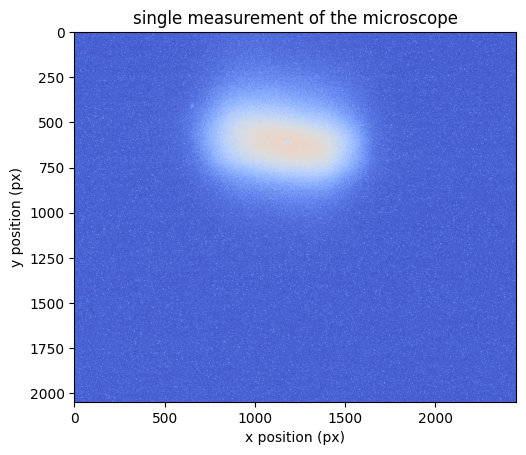

In [67]:
save_path = '/home/bl531/Documents/diamond_images_0628_microscope/'+str(energy)+'/'+str(exposure_time)+'/'
data = np.zeros((100,Ny,Nx))
for folder in range (1):
    for i in range (100):
        filename = save_path + 'images_tiff_'+str(folder+1)+'/'+str(i)+'.tiff'
        #print(filename)
        im_png = Image.open(filename)
        im_png_arr = np.array(im_png)
        data[folder*100+i]=im_png_arr
print(data.shape)
plt.imshow(data[-1])
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of the microscope")

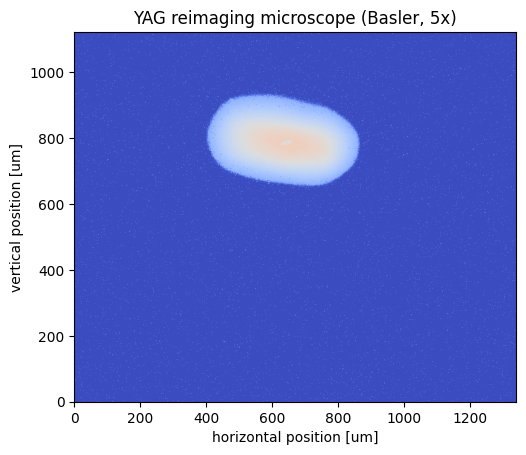

In [68]:
data_avg = np.mean(data,0)
data_avg_masked = np.where(data_avg>(0.25*np.max(data_avg)),data_avg,0)
# plt.imshow(data_avg_masked)
# plt.xlabel("x position (px)")
# plt.ylabel("y position (px)")
# plt.title("masked measurement of microscope")
plt.imshow(data_avg_masked,extent=[x_m[0]*1e6,x_m[-1]*1e6,y_m[0]*1e6,y_m[-1]*1e6])
plt.xlabel('horizontal position [um]')
plt.ylabel('vertical position [um]')
plt.title('YAG reimaging microscope (Basler, 5x)')
plt.show()

In [69]:
center_x_m = centroid1(x_m, np.sum(data_avg_masked,0))
size_x_m = size_rms1(x_m, np.sum(data_avg_masked,0))
print("x-axis center and rms size [um]:",center_x_m*1e6,size_x_m*1e6)

center_y_m = centroid1(y_m, np.sum(data_avg_masked,1))
size_y_m = size_rms1(y_m, np.sum(data_avg_masked,1))
print("y-axis center and rms size [um]:",center_y_m*1e6,size_y_m*1e6)

x-axis center and rms size [um]: 636.062566833128 154.7177832611651
y-axis center and rms size [um]: 350.3786973371151 129.81102715188172


In [70]:
center_x_list=[]
size_x_list=[]
center_y_list=[]
size_y_list=[]
for k in range(data.shape[0]):
    each_data = data[k]

    each_center_x_m = centroid1(x_m, np.sum(each_data,0))
    each_size_x_m = size_rms1(x_m, np.sum(each_data,0))*2.35
    each_center_y_m = centroid1(y_m, np.sum(each_data,1))
    each_size_y_m= size_rms1(y_m, np.sum(each_data,1))*2.35

    center_x_list.append(each_center_x_m*1e6)
    size_x_list.append(each_size_x_m)
    center_y_list.append(each_center_y_m)
    size_y_list.append(each_size_y_m)

centroid error std: 0.5004957447179631 um


Text(0, 0.5, 'frequency')

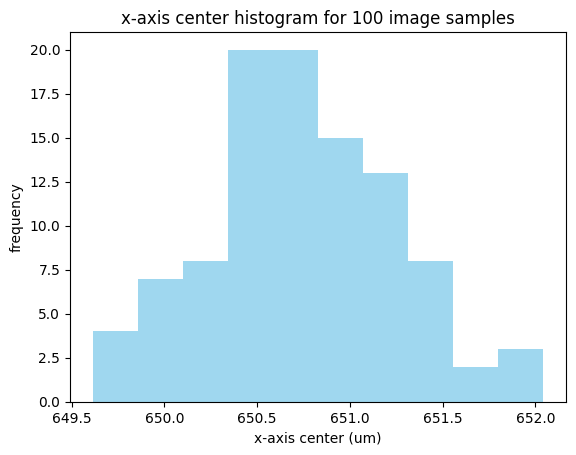

In [71]:
print("centroid error std:",np.std(center_x_list),"um")
plt.hist(center_x_list, bins=10,color='skyblue',alpha=0.8)
plt.title('x-axis center histogram for 100 image samples')
plt.xlabel('x-axis center (um)')
plt.ylabel('frequency')

In [ ]:
basler_camera.destroy()